In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

from sentence_transformers import SentenceTransformer
from imblearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

### Extraction Features

In [2]:
df = pd.read_csv("../PreProcessing/processed_data/Resume_proc.csv")

In [3]:
# Conversione in un formato utile a BERT
resumes = df["Resume_str"].tolist()
    
cat = df["Category"].astype("category")
labels = cat.cat.codes
category_names = list(cat.cat.categories)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(resumes, labels, test_size=0.2, random_state=42, stratify=labels)

In [5]:
sbert_model = SentenceTransformer('all-MiniLM-L12-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\filip\.cache\huggingface\hub\models--sentence-transformers--all-distilroberta-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# Embedding dei testi
X_train_embed = sbert_model.encode(X_train, show_progress_bar=True)
X_test_embed = sbert_model.encode(X_test, show_progress_bar=True)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

### Random Forest Classifier

In [7]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
class_counts = y_train.value_counts()
min_classes = class_counts[class_counts < class_counts.mean()].index.tolist()

print(f"Applicazione di SMOTE alle classi: {min_classes}")

target_size = int(class_counts.max())
sampling_strategy = {cls: target_size for cls in min_classes}

Applicazione di SMOTE alle classi: [4, 23, 3, 14, 2, 5, 8]


In [10]:
pipeline = Pipeline(steps=[
    ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [11]:
param_grid = {
    'clf__n_estimators': [400, 700],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__max_depth' : [5, 7, 9],
    'clf__criterion' : ['gini', 'entropy'],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [15]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_weighted',
    return_train_score=True,
    n_jobs=-1
)

start = time()
grid_search = grid.fit(X_train_embed, y_train)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_)

GridSearchCV took 804.86 seconds for 24 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.516 (std: 0.008)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}

Model with rank: 2
Mean validation score: 0.516 (std: 0.007)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 3
Mean validation score: 0.511 (std: 0.005)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 700}

Model with rank: 4
Mean validation score: 0.511 (std: 0.007)
Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10,

In [12]:
print(grid_search.best_params_)

{'clf__criterion': 'entropy', 'clf__max_depth': 9, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 15, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}


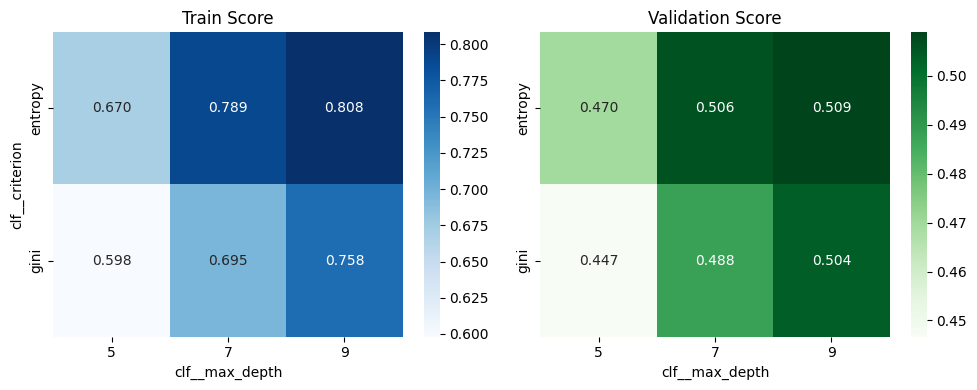

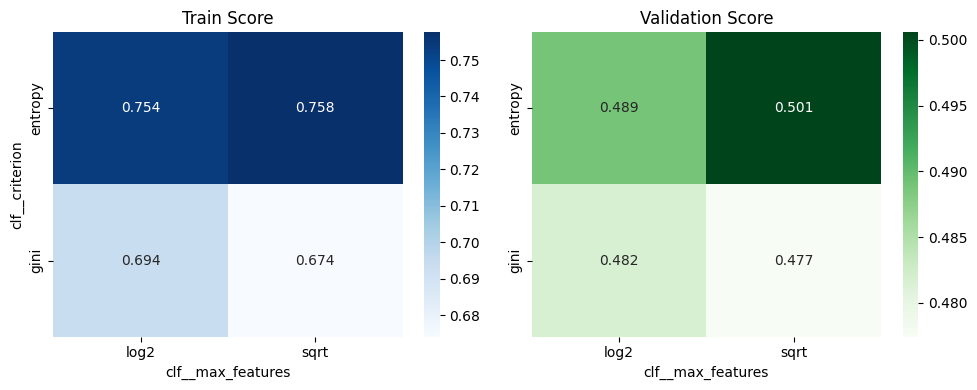

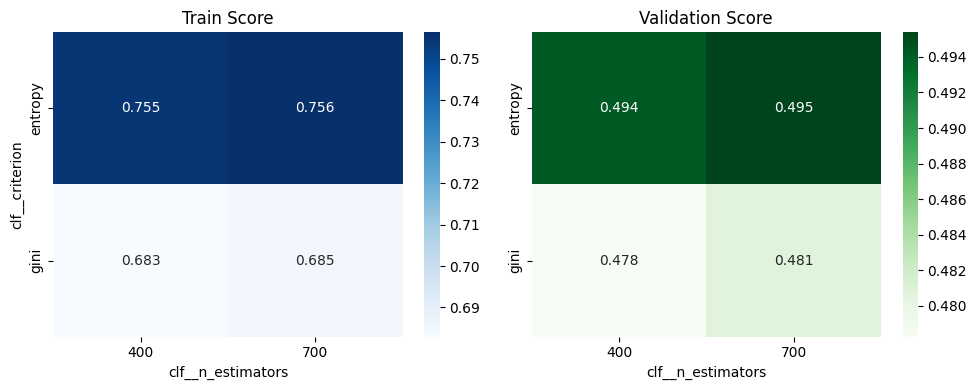

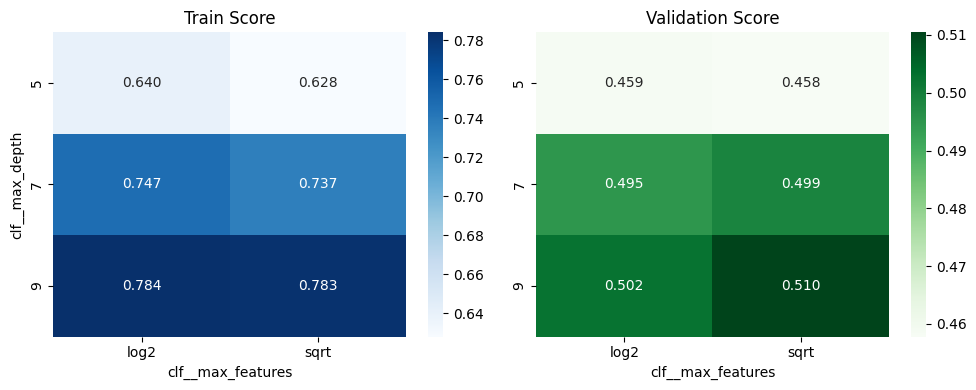

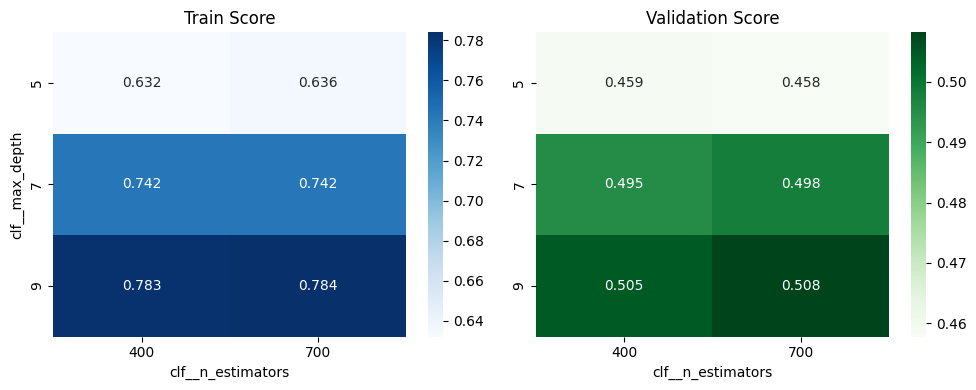

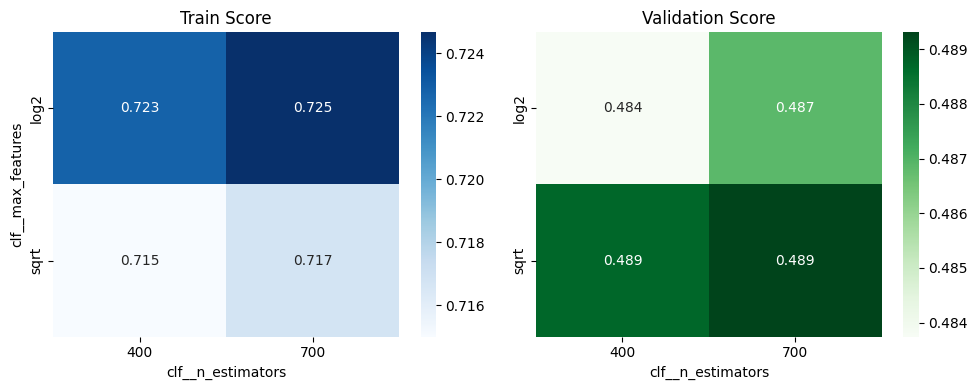

In [13]:
# DataFrame con i risultati
results = pd.DataFrame(grid_search.cv_results_)
param_cols = [col for col in results.columns if col.startswith("param_")]

# Converti tutti i parametri in stringa per la pivot table
for p in param_cols:
    results[p] = results[p].astype(str)

# Heatmap per ogni coppia di parametri
for p1, p2 in combinations(param_cols, 2):
    try:
        pivot_val = results.pivot_table(values='mean_test_score', index=p1, columns=p2)
        pivot_train = results.pivot_table(values='mean_train_score', index=p1, columns=p2)

        if pivot_val.shape[0] > 1 and pivot_val.shape[1] > 1:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            sns.heatmap(pivot_train, annot=True, fmt=".3f", cmap="Blues", ax=axes[0])
            axes[0].set_title(f"Train Score")
            axes[0].set_xlabel(p2.replace("param_", ""))
            axes[0].set_ylabel(p1.replace("param_", ""))

            sns.heatmap(pivot_val, annot=True, fmt=".3f", cmap="Greens", ax=axes[1])
            axes[1].set_title(f"Validation Score")
            axes[1].set_xlabel(p2.replace("param_", ""))
            axes[1].set_ylabel("")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Errore con {p1} e {p2}: {e}")

In [14]:
RF_Model_best = grid_search.best_estimator_
prediction = RF_Model_best.predict(X_test_embed)

In [15]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_embed, y_train)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_embed, y_test)))

Training Score: 0.82
Test Score: 0.60


In [16]:
print(classification_report(y_test, prediction, target_names=category_names, zero_division=0))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.63      0.92      0.75        24
              ADVOCATE       0.44      0.17      0.24        24
           AGRICULTURE       0.75      0.69      0.72        13
               APPAREL       0.67      0.42      0.52        19
                  ARTS       0.80      0.19      0.31        21
            AUTOMOBILE       0.29      0.29      0.29         7
              AVIATION       0.87      0.83      0.85        24
               BANKING       0.67      0.70      0.68        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.59      0.42      0.49        24
                  CHEF       0.83      0.79      0.81        24
          CONSTRUCTION       0.71      0.77      0.74        22
            CONSULTANT       0.00      0.00      0.00        23
              DESIGNER       0.74      0.67      0.70        21
         DIGITAL-MEDIA       0.43      

c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1500x1000 with 0 Axes>

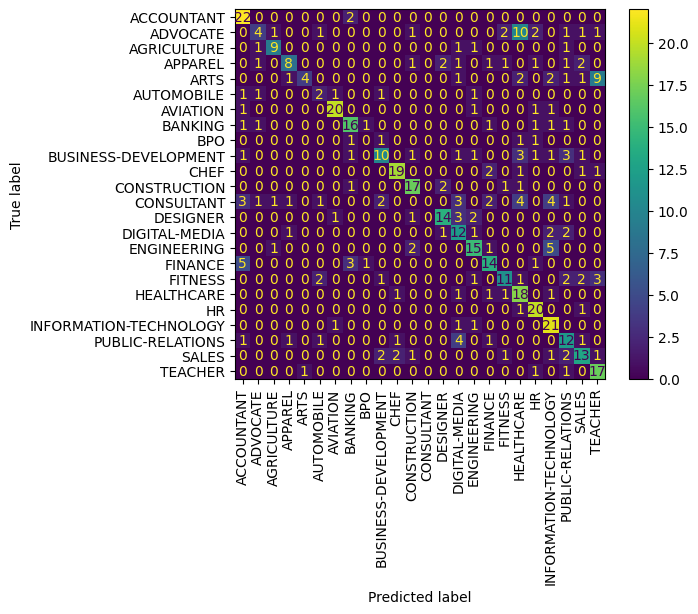

In [17]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction, display_labels=category_names)
plt.xticks(rotation=90)
plt.show()

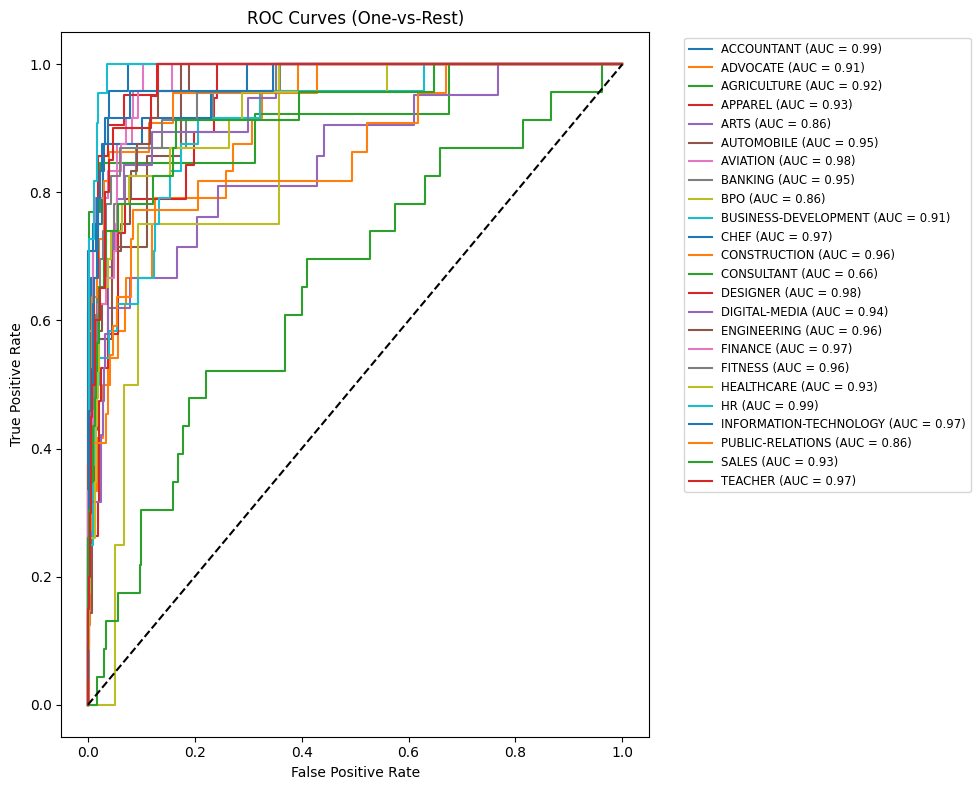

In [18]:
y_test_bin = label_binarize(y_test, classes=RF_Model_best.classes_)
y_score = RF_Model_best.predict_proba(X_test_embed)

plt.figure(figsize=(10, 8))
for i, label in enumerate(category_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

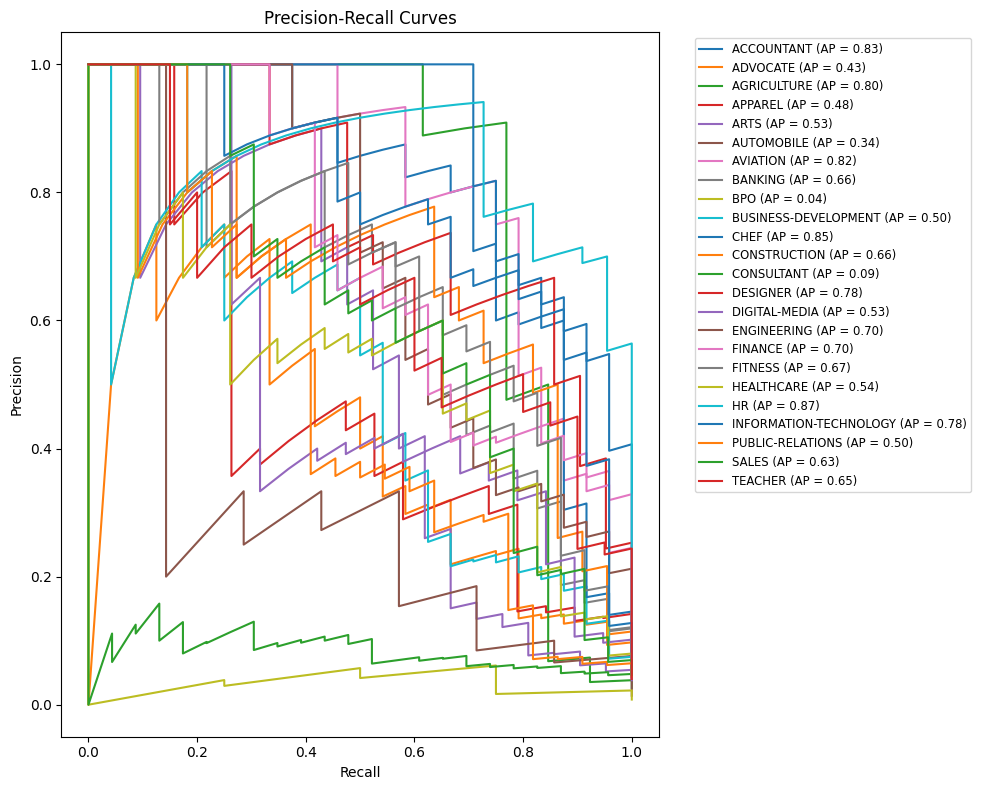

In [19]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(category_names):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f"{label} (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [ ]:
import sys
sys.path.append('..')

from utils import save_experiment_BERT

save_experiment_BERT(grid_search, RF_Model_best, X_train_embed, y_train, X_test_embed, y_test)